<a href="https://colab.research.google.com/github/NguyenYen153/My-code/blob/master/processing2_classical_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install pyvi

     |████████████████████████████████| 8.8MB 5.7MB/s 
     |████████████████████████████████| 747kB 37.1MB/s 


In [0]:

from pyvi import ViTokenizer
import re, os, string
import pandas as pd
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np
import unicodedata as ud
import random
import csv
import time
from tqdm import tqdm
from gensim import utils
from gensim.models.doc2vec import LabeledSentence, TaggedDocument
from gensim.models import Doc2Vec

In [0]:
from sklearn.svm import LinearSVC
from gensim import corpora, matutils
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import nltk

In [0]:
data_path = '/content/drive/My Drive/data/VNFN/'
file_stopwords = 'Dictionaries/Stopwords_vi.txt'
d2v_model_path = 'em_model/doc2vec_model.vec'
w2v_path_pre_trained = 'em_model/cc.vi.300.vec'
w2v_model_path = '/content/drive/My Drive/LuanVan/model/word2vec_skipgram.model'

In [0]:
csv_226 = 'pre_data/preproc_vn_news_226_tlfr.csv' 
csv_223 = 'pre_data/preproc_vn_news_223_tdlfr.csv' 

In [0]:
def DataReader(data_path, csv_path):
    data = []
    with open(os.path.join(data_path, csv_path), 'r') as csv_file:
      reader = csv.DictReader(csv_file)
      data = list(reader)
    return data
def get_data(datas):
    texts = []
    labels = []
    for data in datas:
        texts.append(' '.join(data['text'].split()))
        labels.append(data['label'])
    return texts, labels


In [0]:
datas = DataReader(data_path, csv_226)

In [0]:
texts =[]
labels = []
for train in datas:
    texts.append(' '.join(train['text'].split()))
    labels.append(train['label'])
print(len(texts))


226


In [0]:
#X_text, y_labels
X_train, X_test, y_train, y_test = train_test_split(texts,labels, test_size=0.25)

In [0]:
#print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [0]:
#nltk.download('punkt')

In [0]:
with open(os.path.join(data_path, file_stopwords)) as f:
    list_stopwords = f.read()

#**BUILDING MODELS**

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

##**TFIDF**

In [0]:
#WORD-level
word_tfidf = TfidfVectorizer()
X_train_tfidf = word_tfidf.fit_transform(X_train)
X_test_tfidf = word_tfidf.transform(X_test)
print(X_train_tfidf.shape, X_test_tfidf.shape)
#N-gram level
# ngram level - we choose max number of words equal to 30000 except all words (100k+ words)
ngram_tfidf = TfidfVectorizer(analyzer='word', max_features=30000, ngram_range=(2, 3))
ngram_tfidf.fit(X_train)
X_train_ngram_tfidf =  ngram_tfidf.transform(X_train)
# assume that we don't have test set before
X_test_ngram_tfidf =  ngram_tfidf.transform(X_test)

# ngram-char level - we choose max number of words equal to 30000 except all words (100k+ words)
ngram_char_tfidf = TfidfVectorizer(analyzer='char', max_features=30000, ngram_range=(2, 3))
ngram_char_tfidf.fit(X_train)
X_train_ngram_char_tfidf =  ngram_char_tfidf.transform(X_train)
# assume that we don't have test set before
X_test_ngram_char_tfidfr =  ngram_char_tfidf.transform(X_test)

(169, 7946) (57, 7946)


##**SVD**- giảm chiều dữ liệu

```
# This is formatted as code
```



In [0]:
from sklearn.decomposition import TruncatedSVD
#WORD-level
svd = TruncatedSVD(n_components=300, random_state=42)
svd.fit(X_train_tfidf)

X_train_tfidf_svd = svd.transform(X_train_tfidf)
X_test_tfidf_svd = svd.transform(X_test_tfidf)
#ngram-level
svd_ngram = TruncatedSVD(n_components=300, random_state=42)
svd_ngram.fit(X_train_ngram_tfidf)

X_train_ngram_tfidf_svd = svd_ngram.transform(X_train_ngram_tfidf)
X_test_ngram_tfidf_svd = svd_ngram.transform(X_test_ngram_tfidf)
#ngraml char-level
svd_ngram_char = TruncatedSVD(n_components=300, random_state=42)
svd_ngram_char.fit(X_train_ngram_tfidf)

X_train_ngram_char_tfidf_svd = svd_ngram_char.transform(X_train_ngram_tfidf)
X_test_ngram_char_tfidf_svd = svd_ngram_char.transform(X_test_ngram_tfidf)

##**WORD2VEC**

In [0]:
%%time
w2v = KeyedVectors.load_word2vec_format(os.path.join(data_path, w2v_path_pre_trained))
vocab = w2v.wv.vocab
wv = w2v.wv

def get_word2vec_data(X):
    word2vec_data = []
    for x in X:
        sentence = []
        for word in x.split(" "):
            if word in vocab:
                sentence.append(wv[word])

        word2vec_data.append(sentence)

    return word2vec_data

X_train_w2v = get_word2vec_data(X_train)
X_test_w2v = get_word2vec_data(X_test)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CPU times: user 9min 24s, sys: 6.75 s, total: 9min 31s
Wall time: 9min 38s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
def get_corpus(documents):
    corpus = []
    
    for i in tqdm(range(len(documents))):
        doc = documents[i]
        
        words = doc.split(' ')
        tagged_document = TaggedDocument(words, [i])
        
        corpus.append(tagged_document)
        
    return corpus

In [0]:
 for i in tqdm(range(len(X_train))):
        doc = X_train[i]
        print(doc)

100%|██████████| 169/169 [00:00<00:00, 9742.67it/s]

đức từ_chối cấp visa đoàn công_tác nhà_nước tạm ngừng cấp visa du_học_sinh việt_nam giao_thương hai nước bắt_đầu gặp ảnh_hưởng căng_thẳng ngoại_giao đức – việt sinh_viên học_sinh doanh_nghiệp gánh_chịu hậu_quả phía đức nhận việt_nam thư trả_lời về vụ_việc trịnh_xuân_thanh nội_các chính_phủ nước cuộc họp nhất_trí đưa quyết_định hôm 22 9 tạm_thời đình_chỉ quan_hệ đối_tác chiến_lược giữa đức việt_nam đồng_thời trục_xuất thêm 1 cán_bộ ngoại_giao đại_sứ_quán việt_nam berlin ngày đại_sứ_quán đức hà_nội lập_tức phổ_biến trang_web faecebook mình thông_cáo báo_chí bộ ngoại_đức về quyết_định kể nước trong liên_minh châu âu eu bắt_đầu đồng_hành nước đức gần đồng_loạt đại_sứ_quán nước eu pháp bỉ hà_lan ý thụy_điển đăng facebook mình bản thông_cáo báo_chí bộ ngoại_giao đức ủng_hộ tuyên_bố chính_phủ đức người việt trong ngoài nước bàng_hoàng quyết_định cứng_rắn bộ ngoại_giao đức đưa ngày bầu_cử nói quyết_tâm nước thực_hiện đúng lời tuyên_bố bộ_trưởng bộ ngoại_giao đức_gabriel đưa đối_với việt_nam „ 

In [0]:
train_corpus = get_corpus(X_train)
test_corpus = get_corpus(X_test)

100%|██████████| 57/57 [00:00<00:00, 11053.97it/s]


##**DOC2VEC**

In [0]:
model_d2v = Doc2Vec(vector_size=300, min_count=2, epochs=40)
model_d2v.build_vocab(train_corpus)
%time 
model_d2v.train(train_corpus, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)
model_d2v.save(os.path.join(data_path, d2v_model_path ))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def get_doc2vec_data(model, X_corpus):
    X_vector = []
    for x in X_corpus:
          vector = model.infer_vector(x.words)
          X_vector.append(vector)
    return X_vector

In [0]:
#GET vector of document
X_train_d2v = get_doc2vec_data(model_d2v, train_corpus)
X_test_d2v = get_doc2vec_data(model_d2v, test_corpus)

In [0]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV 
from time import time
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier#решающее дерево
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier#random tree
from sklearn.neighbors import KNeighborsClassifier#k-NN
import lightgbm as lgb#LightGBM 
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve, f1_score, auc, accuracy_score, confusion_matrix, classification_report 
from scipy import interp
from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

In [0]:
def train_model(classifier, X_data, y_data, X_test, y_test, is_neuralnet=False, n_epochs=3):       
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.1, random_state=42)
    
    if is_neuralnet:
        classifier.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=n_epochs, batch_size=512)
        
        val_predictions = classifier.predict(X_val)
        test_predictions = classifier.predict(X_test)
        val_predictions = val_predictions.argmax(axis=-1)
        test_predictions = test_predictions.argmax(axis=-1)
    else:
        classifier.fit(X_train, y_train)
    
        train_predictions = classifier.predict(X_train)
        val_predictions = classifier.predict(X_val)
        test_predictions = classifier.predict(X_test)
        
    print("Validation accuracy: ", metrics.accuracy_score(val_predictions, y_val))
    print("Test accuracy: ", metrics.accuracy_score(test_predictions, y_test))

##**MODEL**

In [0]:
# specify parameters and distributions to sample from
'''model_svm = SVC()
model_dectree = DecisionTreeClassifier()#criterion='gini', splitter='best')
model_linear = LogisticRegression()#multi_class = 'multinomial',solver = 'saga', max_iter = 10000, tol = 0.0001)
model_lgb = lgb.LGBMClassifier()#LightGBM by Microsoft.Градиентный бустинг
model_knn = KNeighborsClassifier()
'''

**FIND PARAMETERS**

In [0]:
#Tìm parameter để kq tốt nhất
param_dist_naive = {'alpha':np.arrange(0,1,0.01)}

C_svm= np.linspace(1,10,10)
kernel =['rbf', 'poly', 'sigmoid']
degree = [2,3,4,5]
gamma = np.linspace(0,1,5)
param_dist_svm ={'C':C__svm,'kernel':kernel, 'degree':degree, 'gamma':gamma}

#2.parameters LogisticRegression
C_lr= np.linspace(1,10,10)
penalty =['l1', 'l2']
param_dist_lr ={'C':C_lr,'penalty':penalty}

#3. parameters DecisionTreeClassifier
max_depth = np.linspace(20, 60, 10)
param_dist_dt ={'max_depth': max_depth}

#4. parameters knn
param_dist_knn = {'n_neighbors':np.linspace(3,15,6), 
                  'weight':['uniform', 'distance'],
                  'metric':['euclidean', 'manhattan']}

#5. for LGBMClassifier
params_lgb = {
    'boosting_type': 'gbdt',#Gradient Boosting Decision Tree
    'objective': 'multiclass',
    'num_leaves': 80,
    'learning_rate': range(0,0.5,0.1)
    'class_weight':None,
    'n_estimators': 100,
     'max_depth': 7
}

# run randomized search
#random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   #cv=5, iid=False)
#viet ham tim parameters tot nhat
def search_best_parameters(model, param_dist, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid=param_dist, cv = 5, scoring = 'accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_estimator_)
    return grid_search

In [0]:
'''def model_pipe(model1, model2,name_models, param_dist, X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
  clf = Pipeline([(name_models[0], model1), name_models[1], model2)])
  clf = GridSearchCV(clf,param_grid=param_dist, cv = 5, scoring = 'accuracy', n_jobs=-1)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  '''

**TFIDF**

In [0]:
model_naive = Pipeline([('vect', Countvectorizer(ngram_range =(1,3))),('tfidf', TfidfTransformer(sublinear_tf=False)),
                      ('svd',TruncatedSVD(n_components=300, random_state=42)),('clf', MultinomialNB())])


In [0]:
best_naive = search_best_parameters(model_naive, param_dist_naive, X_train, y_train)

In [0]:
best_parameters_naive =  MultinomialNB(alpha=best_naive.best_params_['alpha'])
best_parameters_naive.fit(X_train, y_train)
y_pred_naive = best_parameters_naive.predict(X_test)

In [0]:
model_svm = Pipeline([('vect', Countvectorizer(ngram_range =(1,3))),('tfidf', TfidfTransformer(sublinear_tf=False)),
                      ('svd',TruncatedSVD(n_components=300, random_state=42)),('clf', SVC())])


In [0]:
best_svm = search_best_parameters(model_svm, param_dist_svm, X_train, y_train)

SVC(C=2.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [0]:
best_parameters_svm = SVC(C=best_svm.best_params_['C'] , degree=best_svm.best_params_['degree'], gamma=best_svm.best_params_['gamma'], kernel=best_svm.best_params_['kernel'])
best_parameters_svm.fit(X_train, y_train)
y_pred_svm = best_parameters_svm.predict(X_test)

In [0]:
model_lr = Pipeline([('vect', Countvectorizer(ngram_range =(1,3))),('tfidf', TfidfTransformer(sublinear_tf=False)),
                      ('svd',TruncatedSVD(n_components=300, random_state=42)),('clf',LogisticRegression() )])

In [0]:
best_lr = search_best_parameters(model_lr, param_dist_lr, X_train, y_train)

In [0]:
best_parameters_lr = LogisticRegression(C=best_lr.best_params_['C'] , penalty=best_lr.best_params_['penalty'])
best_parameters_lr.fit(X_train, y_train)
y_pred_lr = best_parameters_lr.predict(X_test)

In [0]:
model_dectree = Pipeline([('vect', Countvectorizer(ngram_range =(1,3))),('tfidf', TfidfTransformer(sublinear_tf=False)),
                      ('svd',TruncatedSVD(n_components=300, random_state=42)),('clf',DecisionTreeClassifier(criterion='gini', splitter='best')])

In [0]:
best_dectree = search_best_parameters(model_dectree, param_dist_dt, X_train, y_train)

In [0]:
best_parameters_dectree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=best_dectree.best_params_['max_depth'])
best_parameters_dectree.fit(X_train, y_train)
y_pred_dectree = best_parameters_dectree.predict(X_test)

In [0]:
model_knn = Pipeline([('vect', Countvectorizer(ngram_range =(1,3))),('tfidf', TfidfTransformer(sublinear_tf=False)),
                      ('svd',TruncatedSVD(n_components=300, random_state=42)),('clf',KNeighborsClassifier()])

In [0]:
best_knn = search_best_parameters(model_knn, param_dist_knn, X_train, y_train)

In [0]:
best_parameters_knn = KNeighborsClassifier(n_neighbors=best_lr.best_params_['n_neighbors'], 
                                           weight=best_lr.best_params_['weight'], metric=best_lr.best_params_['metric'])
best_parameters_knn.fit(X_train, y_train)
y_pred_knn= best_parameters_knn.predict(X_test)

In [0]:
model_lgb = Pipeline([('vect', Countvectorizer(ngram_range =(1,3))),('tfidf', TfidfTransformer(sublinear_tf=False)),
                      ('svd',TruncatedSVD(n_components=300, random_state=42)),('clf',lgb.LGBMClassifier())])

In [0]:
best_lgb = search_best_parameters(model_lgb, param_dist_lgb, X_train, y_train)

In [0]:
best_parameters_lgb = lgb.LGBMClassifier()#copy and paste parameters from best_lgb
best_parameters_lr.fit(X_train, y_train)
y_pred_lgb = best_parameters_lgb.predict(X_test)

In [0]:
#Ensemble model
ensemble_clf = VotingClassifier(estimators=[('svm',model_svm),('lr',model_lr),('naive',model_naive),('dectree', model_dectree),
                                            ('knn', model_knn),('lgb',model_lgb)], voting ='hard')


In [0]:
ensemble_clf.fit(X_train, y_train)
y_pred_ensemble = ensemble_clf.predict(X_test)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[32  0]
 [ 5 20]]


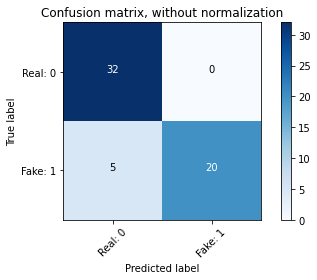

In [0]:
cnf_matrix = confusion_matrix(y_test, y_pred_svm)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = ['Real: 0', 'Fake: 1'],
                      title='Confusion matrix, without normalization')

In [0]:
print(classification_report(y_test, y_pred_svc, target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.83      0.86      0.84        28
        Fake       0.86      0.83      0.84        29

    accuracy                           0.84        57
   macro avg       0.84      0.84      0.84        57
weighted avg       0.84      0.84      0.84        57



In [0]:
#get  file  .py
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

model_training_module = drive.CreateFile({'id':''})
model_training_module.GetContentFile('model_traing.py')


In [0]:
from model_traininng import LSTMClassifier, CNN, RNN, AttentionModel

##**LSTM**

##**RNN**

